# Andrea Di Simone
## Test for Check24

# Table of Contents <a class="anchor" id="TOC"></a>

* [Setting up the environment](#environment)
* [Reading and inspecting the inputs](#reading)
  * [Feature plots](#featureplots)
  * [Feature correlation](#featurecorr)
* [Creating the inputs for the model fitting](#inputs)
* [Model Cross-Validation and optimization](#model)
* [Inspection of results](#inspection)
* [Comments](#comments)


# Setting up the environment <a class="anchor" id="environment"></a>

Some relevant imports are executed here. The plot style is also chosen, and interactive plotting is selected.

[to top](#TOC)

In [140]:
# Imports

from collections import defaultdict

# pandas
import pandas as pd
from pandas import Series,DataFrame
pd.options.display.max_colwidth=100
    
from IPython.display import display

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectPercentile, SelectFromModel

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, make_scorer


# Reading/inspecting the inputs <a class="anchor" id="reading"></a>
The following code reads the csv file in a `DataFrame` and inspects the contents. There are no NaN values that need to be fixed. Categorical variables are represented by strings, but they are regularly formatted, so no further manipulation will be needed. **The fraction of success of the campaign is 12.7%**

[to top](#TOC)

In [96]:
input_df = pd.read_csv('bank-marketing-data.csv',sep=';')

input_df.info()
display(input_df.head())

input_df.Subscription.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
Age                 41188 non-null int64
Job                 41188 non-null object
Marital             41188 non-null object
Education           41188 non-null object
Default             41188 non-null object
Housing             41188 non-null object
Loan                41188 non-null object
Contact             41188 non-null object
Month               41188 non-null object
Day_Of_Week         41188 non-null object
Duration            41188 non-null int64
Campaign            41188 non-null int64
Passed_Days         41188 non-null int64
Previous            41188 non-null int64
Previous_Outcome    41188 non-null object
Emp_Var_Rate        41188 non-null float64
Cons_Price_Index    41188 non-null float64
Cons_Conf_Index     41188 non-null float64
Euribor3m           41188 non-null float64
Nr_Employed         41188 non-null float64
Subscription        41188 non-null object
dtypes: f

,Age,Job,Marital,Education,Default,Housing,Loan,Contact,Month,Day_Of_Week,...,Campaign,Passed_Days,Previous,Previous_Outcome,Emp_Var_Rate,Cons_Price_Index,Cons_Conf_Index,Euribor3m,Nr_Employed,Subscription
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


no     36548
yes     4640
Name: Subscription, dtype: int64

## Features plots <a class="anchor" id="featureplots"></a>

We inspect here the features in the training set. Forst, we split the feature by type (i.e. numerical vs categorical)

In [97]:
numericals=[x for x in input_df.columns if ( input_df[x].dtype==np.dtype('int64') or input_df[x].dtype==np.dtype('float64'))]
categoricals=[x for x in input_df.columns if input_df[x].dtype==np.dtype('object')]
print "Numerical fields",numericals
print "Categorical fields",categoricals

Numerical fields ['Age', 'Duration', 'Campaign', 'Passed_Days', 'Previous', 'Emp_Var_Rate', 'Cons_Price_Index', 'Cons_Conf_Index', 'Euribor3m', 'Nr_Employed']
Categorical fields ['Job', 'Marital', 'Education', 'Default', 'Housing', 'Loan', 'Contact', 'Month', 'Day_Of_Week', 'Previous_Outcome', 'Subscription']


For the categoricals, I prefer to **convert string to numbers**, since it allows to plot easily the correlations

In [98]:
cat_mapping={}
cat_mapping_reverse={}

for feat in categoricals:
    # sort categories by most populated
    values=input_df[feat].value_counts().index
#    print values
    cat_mapping[feat]=dict(zip(values,range(len(values))))
    cat_mapping_reverse[feat]=dict(zip(range(len(values)),values))
    input_df[feat]=input_df[feat].replace(cat_mapping[feat])

#print cat_mapping
#input_df.head()
#input_df.tail()
#input_df.info()

Now, we produce histograms for the numerical features, and bar plots for the categoricals. Note that the categoricals are, under the hood, now integers, no more strings

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f165a881dd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f16593e5610>]], dtype=object)

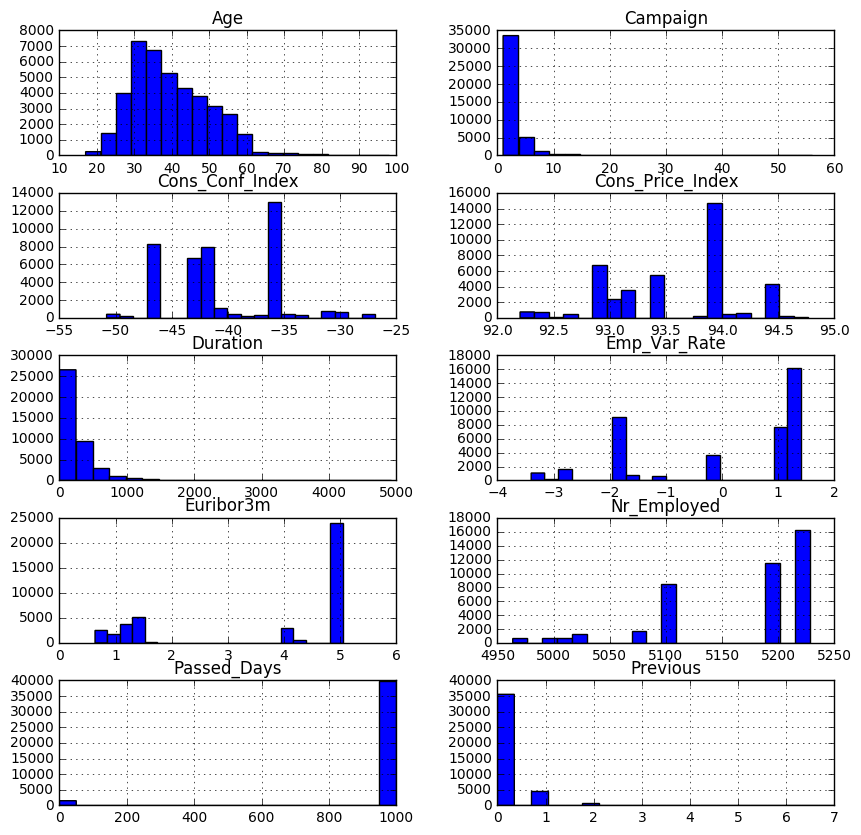

In [99]:
input_df[numericals].hist(bins=20,layout=(5,2),figsize=(10,10))

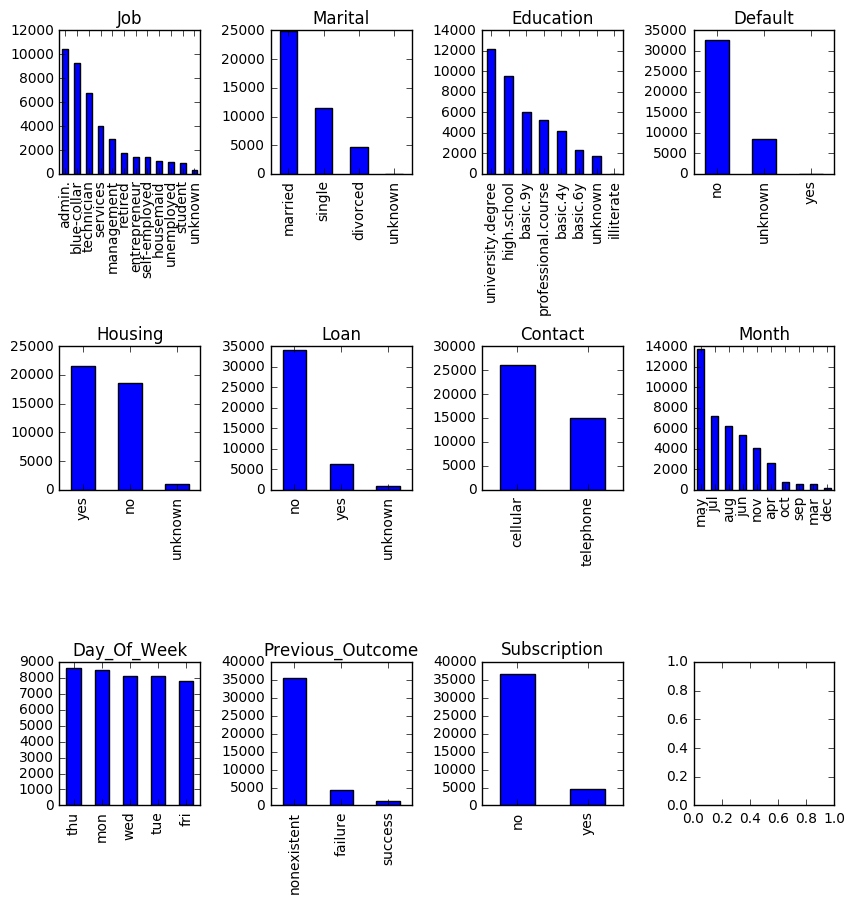

In [100]:

f,ax=plt.subplots(3,4,figsize=(10,10))

for i,var in enumerate(categoricals):
    indices=(int(i/4),i%4)
    input_df[var].value_counts().plot(kind='bar',ax=ax[indices])
    ax[indices].set_title(var)
    xticklabels=[cat_mapping_reverse[var][x] for x in sorted(cat_mapping_reverse[var])]
    ax[indices].set_xticklabels(xticklabels)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=1.2)


## Features Correlation <a class="anchor" id="featurecorr"></a>

We start investigating here the correlations between variables. The target valiable is represented here by the last column/row.

A few considerations:

* **Subscription** is moderately anti-correlated with **Passed_Days**. Even taking into account that **Passed_Days** has many "999" values, this seems to suggest that subscription is more likely after repeated contacts
* **Subscription** is, on the other hand,  positively correlated with **Duration**, which suggests a preference for longer calls
* **Subscription** is also positively correlated with **Previous** and  **Previous_Outcome**, which are, on the other hand, strongly correlated with each other. This suggests that **previous subscribers are likely to subscribe again**.
* **Subscription** is anti-correlated with **Cons_Price_Index** and positively correlated with **Cons_Conf_index** which suggests more propension to subscription in relatively stable contexts, as far as consumers are concerned. The same argument holds for the anti-correlation with **Emp_Var_Rate**.
* The anti-correlation of **Subscription** and **Euribor3m** indicates that consumers are more likely to subscribe to long-term investments plans when the yield of short-term deposits is low.
* I am honestly not clear I understand the meaning and the values of **Nr_Employed**, and I woujld therefore refrain from commenting on its link to the subscription probability

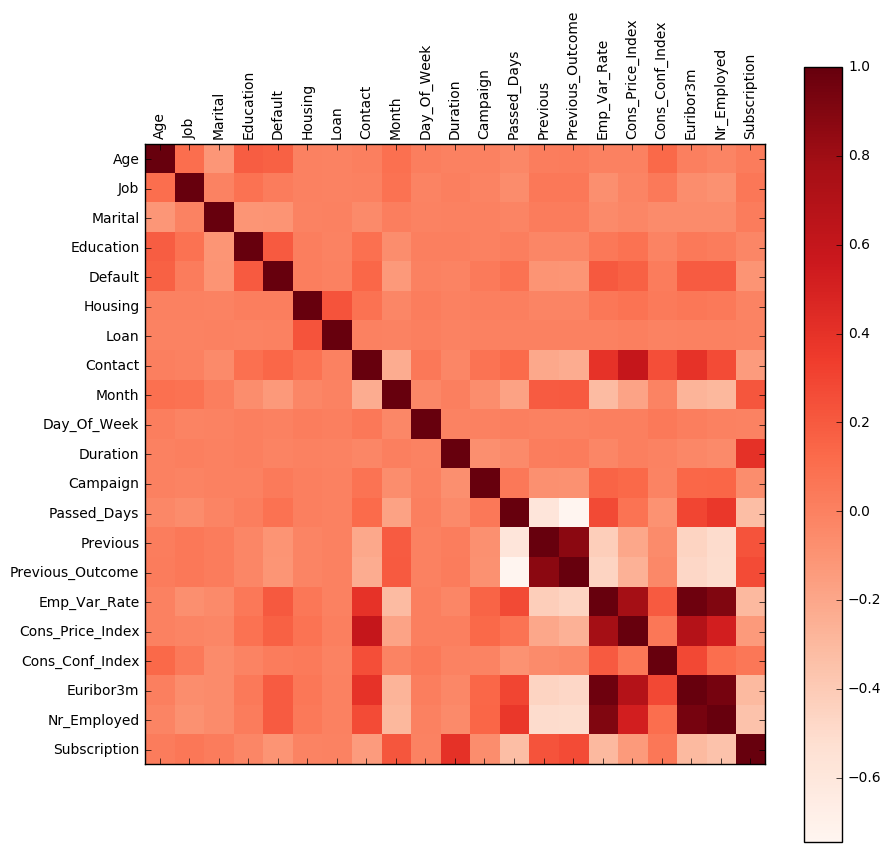

In [101]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # to have ticks at every bin

inputs_corr=input_df.corr()

f,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.matshow(inputs_corr,cmap='Reds')
ax.set_xticklabels(['']+list(input_df.columns),rotation='vertical')
ax.set_yticklabels(['']+list(input_df.columns))
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
f.colorbar(im)

# Creating the inputs for the model fitting <a class="anchor" id="inputs"></a>

We will now try to build a model to estimate the success of a campaign. All the categorical variables undergo OneHotEncoding, all the numerical variables are scaled. As a first try, a LogisticRegression is fitted to the data. The regularization parameters of the model is optimized using a grid search with cross validation.

In order to evaluate the accuracy of the model, I separate the inputs into a training and a testing subset.

A second model (RandomForestClassifier) is also trained and evaluated. The perameters being optimized in this case are the nymber of random trees in the forest and the minimum number of entries required to split a leaf.



In [194]:
X_df=input_df.drop('Subscription',axis=1)
Y_df=input_df['Subscription']

# split columns for different preprocessing
numericals_idx=np.array([(column in numericals and column!="Duration") for column in X_df.columns], dtype = bool)
categoricals_idx=np.array([(column in categoricals) for column in X_df.columns], dtype = bool)
log1p_idx=np.array([(column in numericals and column=="Duration") for column in X_df.columns], dtype = bool)

print numericals_idx
print categoricals_idx
print log1p_idx

[ True False False False False False False False False False False  True
  True  True False  True  True  True  True  True]
[False  True  True  True  True  True  True  True  True  True False False
 False False  True False False False False False]
[False False False False False False False False False False  True False
 False False False False False False False False]


In [202]:
Xtrain_df, Xtest_df, Ytrain_df, Ytest_df = train_test_split(X_df,Y_df,test_size=.20, random_state=0)

# the transformer does the preprocessings for the three different types
transformer_list = [        
                    
            #numeric
            ('numeric_variables_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, numericals_idx])),
                ('scaling', MinMaxScaler())            
                        ])),   
            #categorical
            ('categorical_variables_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, categoricals_idx])),
                ('hot_encoding', OneHotEncoder())            
                        ])),
            # log transformer
            ('log1p_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, log1p_idx])),
                ('log1p',FunctionTransformer(np.log1p)),
                ('scaling', MinMaxScaler())
                ]))
        ]

In [203]:
                                          
                                          
pipe_logreg = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list=transformer_list)),
    ('logreg', LogisticRegression(class_weight='balanced'))
    ]
)


grid_logreg={
    'logreg__C':[1.0,10,100,500,1000],
}


gsearch_logreg=GridSearchCV(pipe_logreg,grid_logreg,cv=5)
gsearch_logreg.fit(Xtrain_df.values,Ytrain_df.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f1651b18de8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pas...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1.0, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [204]:
# change scoring, maximize the area below the recall/precision curve
pipe_logreg2 = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list=transformer_list)),
    ('logreg', LogisticRegression(class_weight='balanced'))
    ]
)

#gsearch_logreg2=GridSearchCV(pipe_logreg2,grid_logreg,cv=5, scoring=make_scorer(average_precision_score))
gsearch_logreg2=GridSearchCV(pipe_logreg2,grid_logreg,cv=5, scoring='recall')

gsearch_logreg2.fit(Xtrain_df.values,Ytrain_df.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f1651b18de8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pas...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1.0, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

In [210]:
print gsearch_logreg.best_params_
print gsearch_logreg2.best_params_


print "Best score with LogisticRegression\n",gsearch_logreg.best_score_
print "Best score with LogisticRegression2\n",gsearch_logreg2.best_score_

#print "Logistic regression coefficients", gsearch_logreg.best_estimator_.named_steps['logreg'].coef_



{'logreg__C': 100}
{'logreg__C': 10}
Best score with LogisticRegression
0.85908952959
Best score with LogisticRegression2
0.897877495123


In [213]:
pipe_forest = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list=transformer_list)),
    ('forest', RandomForestClassifier(class_weight='balanced'))
    ]
)


grid_forest={
    'forest__n_estimators':[10,20,50,70,100,200],
    'forest__min_samples_split':[2,4,6,12,18,24],
    'forest__criterion':['gini','entropy']
}

gsearch_forest=GridSearchCV(pipe_forest,grid_forest,cv=5,scoring='recall')


gsearch_forest.fit(Xtrain_df.values,Ytrain_df.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f1651b18de8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pas...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'forest__criterion': ['gini', 'entropy'], 'forest__n_estimators': [10, 20, 50, 70, 100, 200], 'forest__min_samples_split': [2, 4, 6, 12, 18, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

In [211]:
print "Best score with RandomForestClassifier",gsearch_forest.best_score_
print "Best parameters with RandomForestClassifier",gsearch_forest.best_parameters_

Best score with RandomForestClassifier 0.856487393617


ClassificationReport for LogReg
             precision    recall  f1-score   support

          0       0.99      0.86      0.92      7319
          1       0.44      0.91      0.60       919

avg / total       0.93      0.86      0.88      8238

ClassificationReport for LogReg2
             precision    recall  f1-score   support

          0       0.99      0.86      0.92      7319
          1       0.44      0.91      0.60       919

avg / total       0.93      0.86      0.88      8238

ClassificationReport for Forest
             precision    recall  f1-score   support

          0       0.98      0.89      0.94      7319
          1       0.51      0.87      0.64       919

avg / total       0.93      0.89      0.90      8238

Confusion matrix for LogReg
[[6263 1056]
 [  81  838]]
Confusion matrix for LogReg2
[[6266 1053]
 [  80  839]]
Confusion matrix for Forest
[[6546  773]
 [ 123  796]]
Foresst classes  [0 1]


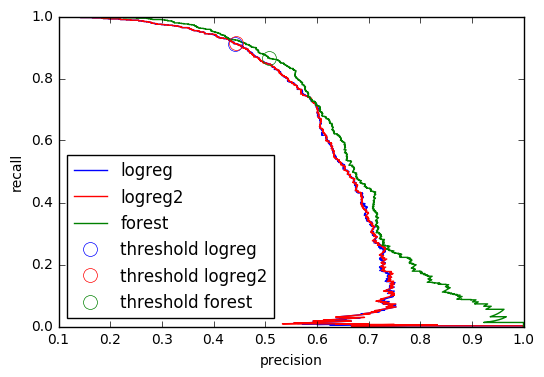

In [236]:


print 'ClassificationReport for LogReg\n',classification_report(Ytest_df.values,gsearch_logreg.predict(Xtest_df.values))
print 'ClassificationReport for LogReg2\n',classification_report(Ytest_df.values,gsearch_logreg2.predict(Xtest_df.values))
print 'ClassificationReport for Forest\n',classification_report(Ytest_df.values,gsearch_forest.predict(Xtest_df.values))

print 'Confusion matrix for LogReg\n',confusion_matrix(Ytest_df.values,gsearch_logreg.predict(Xtest_df.values))
print 'Confusion matrix for LogReg2\n',confusion_matrix(Ytest_df.values,gsearch_logreg2.predict(Xtest_df.values))
print 'Confusion matrix for Forest\n',confusion_matrix(Ytest_df.values,gsearch_forest.predict(Xtest_df.values))


precision,recall,thr=precision_recall_curve(Ytest_df.values,gsearch_logreg.decision_function(Xtest_df.values),pos_label=1)
precision2,recall2,thr2=precision_recall_curve(Ytest_df.values,gsearch_logreg2.decision_function(Xtest_df.values),pos_label=1)
precisionf,recallf,thrf=precision_recall_curve(Ytest_df.values,gsearch_forest.predict_proba(Xtest_df.values)[:,1],pos_label=1)

# need this to interpret the classes from the forest
print "Forest classes ",gsearch_forest.best_estimator_.named_steps['forest'].classes_

# precision = tp / (tp + fp)
# recall = tp / (tp + fn)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(precision,recall, label='logreg',c='b')
ax.plot(precision2,recall2, label='logreg2',c='r')
ax.plot(precisionf,recallf, label='forest',c='g')
ax.set_xlabel('precision')
ax.set_ylabel('recall')

# draw thresholds

# logistic regression has by default threshold at 0, forest at 0.5

default_thr_idx_logreg=np.argmin(np.abs(thr))
default_thr_idx_logreg2=np.argmin(np.abs(thr2))
default_thr_idx_forest=np.argmin(np.abs(thrf-0.5))

ax.plot(precision[default_thr_idx_logreg], recall[default_thr_idx_logreg],'o',markersize=10,fillstyle='none',label='threshold logreg',c='b')
ax.plot(precision2[default_thr_idx_logreg2], recall2[default_thr_idx_logreg2],'o',markersize=10,fillstyle='none',label='threshold logreg2',c='r')
ax.plot(precisionf[default_thr_idx_forest], recallf[default_thr_idx_forest],'o',markersize=10,fillstyle='none',label='threshold forest',c='g')

ax.legend(loc='lower left',numpoints=1)



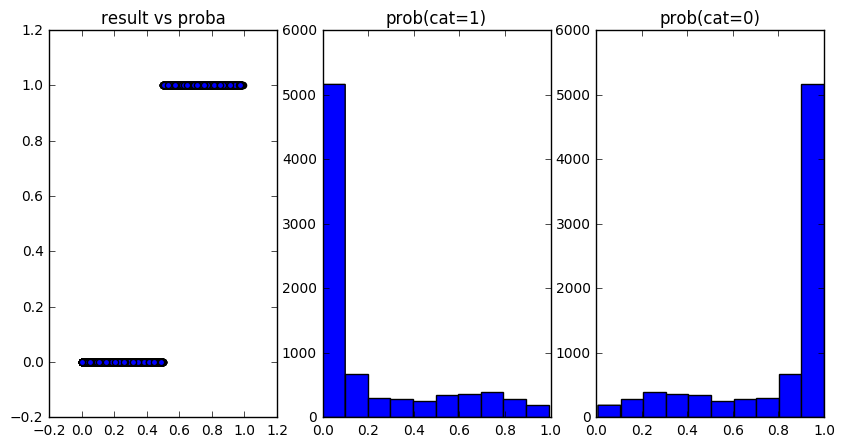

In [238]:
# a look at the decision functions to find default thresholds
f,ax=plt.subplots(1,3,figsize=(10,5))
ax[0].scatter(gsearch_forest.predict_proba(Xtest_df.values)[:,1],gsearch_forest.predict(Xtest_df.values))
ax[0].set_title('result vs proba')
ax[1].hist(gsearch_forest.predict_proba(Xtest_df.values)[:,1],bins=10)
ax[1].set_title('prob(cat=1)')
ax[2].hist(gsearch_forest.predict_proba(Xtest_df.values)[:,0],bins=10)
ax[2].set_title('prob(cat=0)');


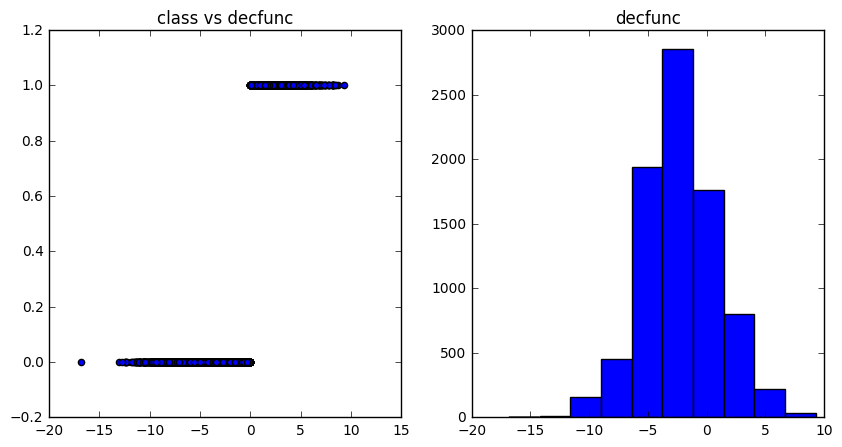

In [241]:
f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(gsearch_logreg.decision_function(Xtest_df.values),gsearch_logreg.predict(Xtest_df.values))
ax[0].set_title('class vs decfunc')
ax[1].hist(gsearch_logreg.decision_function(Xtest_df.values),bins=10)
ax[1].set_title('decfunc');

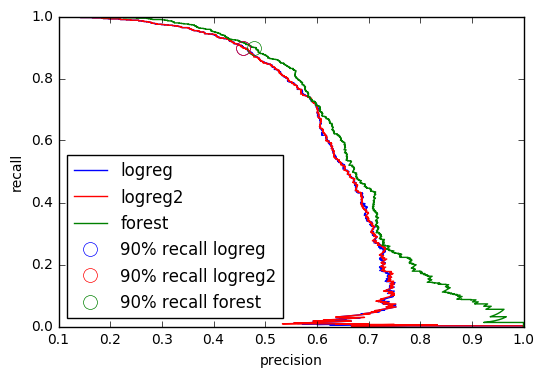

In [242]:
# exercise, let's choose an operating point based on recall
# let's say we want 90% recall

target_recall=0.9
custom_thr_idx_logreg=np.argmin(np.abs(recall-target_recall))
custom_thr_idx_logreg2=np.argmin(np.abs(recall2-target_recall))
custom_thr_idx_forest=np.argmin(np.abs(recallf-target_recall))

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(precision,recall, label='logreg',c='b')
ax.plot(precision2,recall2, label='logreg2',c='r')
ax.plot(precisionf,recallf, label='forest',c='g')
ax.set_xlabel('precision')
ax.set_ylabel('recall')

# draw thresholds

ax.plot(precision[custom_thr_idx_logreg], recall[custom_thr_idx_logreg],'o',markersize=10,fillstyle='none',label='90% recall logreg',c='b')
ax.plot(precision2[custom_thr_idx_logreg2], recall2[custom_thr_idx_logreg2],'o',markersize=10,fillstyle='none',label='90% recall logreg2',c='r')
ax.plot(precisionf[custom_thr_idx_forest], recallf[custom_thr_idx_forest],'o',markersize=10,fillstyle='none',label='90% recall forest',c='g')

ax.legend(loc='lower left',numpoints=1);


In [222]:
# so, forest gives us a biut more precision for the same recall. That will be our baseline result

forest_result=np.where(gsearch_forest.predict_proba(Xtest_df.values)[:,1]>thrf[custom_thr_idx_forest],1,0)


In [223]:
forest_result

array([1, 0, 0, ..., 1, 0, 0])

In [230]:
np.bincount(forest_result)

array([6507, 1731])

In [232]:
print 'ClassificationReport for 90% recall Forest\n',classification_report(Ytest_df.values,forest_result)

print 'Confusion matrix for 90% recall Forest\n',confusion_matrix(Ytest_df.values,forest_result)


ClassificationReport for 90% recall Forest
             precision    recall  f1-score   support

          0       0.99      0.88      0.93      7319
          1       0.48      0.90      0.62       919

avg / total       0.93      0.88      0.89      8238

Confusion matrix for 90% recall Forest
[[6415  904]
 [  92  827]]


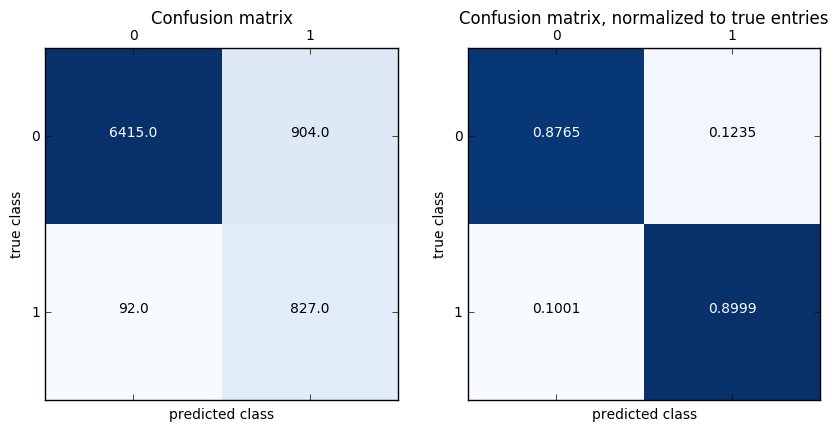

In [280]:
import itertools

# plot confusion matrix
mat=confusion_matrix(Ytest_df.values,forest_result).astype('float')
# the slice turns a list into a column
mat_sum=mat.sum(axis=1)[:,np.newaxis]

mat_norm=mat/mat_sum

#print mat,mat_sum,"\n",mat/mat_sum

f,ax=plt.subplots(1,2,figsize=(10,5))
classes=gsearch_forest.best_estimator_.named_steps['forest'].classes_
ax[0].matshow(mat,cmap='Blues')
ax[0].set_xlabel('predicted class')
ax[0].set_ylabel('true class');
ax[0].set_title("Confusion matrix")

# write values
thresh = mat.max() / 2.
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    ax[0].text(j, i, mat[i, j],
        horizontalalignment="center",
        color="white" if mat[i, j] > thresh else "black")

ax[1].matshow(mat_norm,cmap='Blues')
ax[1].set_xlabel('predicted class')
ax[1].set_ylabel('true class')
ax[1].set_title("Confusion matrix, normalized to true entries");

thresh = mat_norm.max() / 2.

for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    ax[1].text(j, i, round(mat_norm[i, j],4),
        horizontalalignment="center",
        color="white" if mat_norm[i, j] > thresh else "black")